In [62]:
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from sklearn import svm
from sklearn.svm import SVC
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tsaug import Drift,Reverse,AddNoise,Pool,Quantize
torch.manual_seed(111)
np.random.seed(111)

Class 0 72471 Examples
Class 1 2223 Examples
Class 2 5788 Examples
Class 3 641 Examples
Class 4 6431 Examples


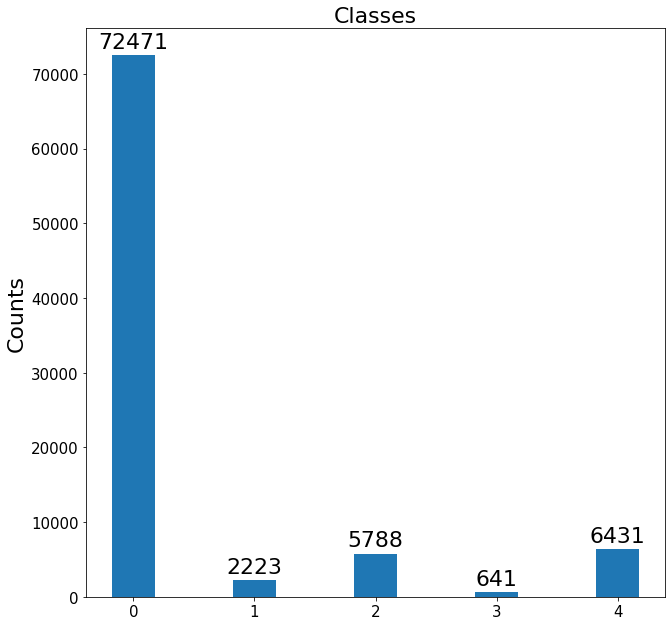

In [6]:
def plot_examples(labels,counts,file_name='mitdb.png'):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, counts, width, label='Class Distribution')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts',fontsize=22)
    ax.set_title('Classes',fontsize=22)
    ax.set_xticks(x)
    
    


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for indx,rect in enumerate(rects):
            height = counts[indx]
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=22)


    autolabel(rects1)

    fig.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(file_name)
    #plt.show()


train_data_mit = np.genfromtxt('mitbih_train.csv', delimiter=',')
test_data_mit=np.genfromtxt('mitbih_test.csv',delimiter=",")

"""indices=train_data_mit[:,-1]!=0.0
train_data_mit[indices,-1]=1.0

indices=test_data_mit[:,-1]!=0.0
test_data_mit[indices,-1]=1.0
#print(test_data_mit)
test_label_types=np.unique(test_data_mit[:,-1])
print(test_label_types)

for values in test_label_types:
    print("Class {0} {1} Examples".format(int(values),np.sum(test_data_mit[:,-1]==values)))
    print(np.sum(test_data_mit[:,-1]==values))
    #examples_per_class.append(np.sum(train_data_mit[:,-1]==values))
#print(np.unique(test_data_mit[:,-1]))
"""
label_types = np.unique(train_data_mit[:,-1])
examples_per_class=[]

for values in label_types:
    print("Class {0} {1} Examples".format(int(values),np.sum(train_data_mit[:,-1]==values)))
    examples_per_class.append(np.sum(train_data_mit[:,-1]==values))

plot_examples(label_types,examples_per_class)

#train_labels_mit=train_data_mit[:,-1]
#train_data_mit=train_data_mit[:,:-1]


In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 4, 3)
        self.bn1=nn.BatchNorm1d(4)
        
        
        
        self.conv2 = nn.Conv1d(4, 16, 3)
        self.bn2=nn.BatchNorm1d(16)
        
        self.conv3 = nn.Conv1d(16, 64, 3)
        self.bn3=nn.BatchNorm1d(64)
        
        self.conv4 = nn.Conv1d(64, 128, 3)
        self.bn4=nn.BatchNorm1d(128)
        
        
        
        self.fc1 = nn.Linear(128 * 9, 128 * 9)
        self.fc2 = nn.Linear(128 * 9, 5)
        #self.predict=nn.Softmax(dim=1)
        
    def forward(self, x):
        x=F.avg_pool1d(F.relu(self.bn1(self.conv1(x))),2)
        x=F.avg_pool1d(F.relu(self.bn2(self.conv2(x))),2)
        x=F.avg_pool1d(F.relu(self.bn3(self.conv3(x))),2)
        x=F.avg_pool1d(F.relu(self.bn4(self.conv4(x))),2)
        
        #print(x.size())
        
        """
        x=F.dropout(F.avg_pool1d(F.relu(self.bn1(self.conv1(x))),2),p=0.1)
        x=F.dropout(F.avg_pool1d(F.relu(self.bn2(self.conv2(x))),2),p=0.1)
        x=F.dropout(F.avg_pool1d(F.relu(self.bn3(self.conv3(x))),2),p=0.1)
        x=F.dropout(F.avg_pool1d(F.relu(self.bn4(self.conv4(x))),2),p=0.1)
        """
        
        #x=F.avg_pool1d(F.relu(self.bn1(self.conv1(x))),2)
        #x=F.avg_pool1d(F.relu(self.bn2(self.conv2(x))),2)
        #print(x.size())
        #x=F.dropout(F.avg_pool1d(F.relu(self.bn3(self.conv3(x))),2),p=0.5)
        
        x = x.view(-1, self.num_flat_features(x))
        
        x=F.relu(self.fc1(x))
        #x = F.dropout(F.relu(self.fc1(x)),p=0.1)
        x = F.relu(self.fc2(x))
        #x=F.dropout(F.relu(self.fc2(x)),p=0.1)
        #x=self.predict(x)
        return x
    
    def feature_extract(self,x):
        x=F.avg_pool1d(F.relu(self.bn1(self.conv1(x))),2)
        x=F.avg_pool1d(F.relu(self.bn2(self.conv2(x))),2)
        x=F.avg_pool1d(F.relu(self.bn3(self.conv3(x))),2)
        x=F.avg_pool1d(F.relu(self.bn4(self.conv4(x))),2)
        x = x.view(-1, self.num_flat_features(x))
        #print(x.size())
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            #print(s)
            num_features *= s
        return num_features

In [43]:
def init(weights=None):
    net=CNN()
    loss=nn.CrossEntropyLoss(weight=weights)
    _optim=optim.Adam(net.parameters(),lr=0.001)
    return net,loss,_optim

In [192]:
#Train Validation Split
def test_train_split(X,Y,random_state=1,split=0.8):
    return train_test_split(X,Y,train_size=split,stratify=Y)
#Train validation split for ot
#print(train_data_mit.shape)
train_data_mit,train_labels_mit=train_data_mit[:,:-1],train_data_mit[:,-1]
#print(train_data_mit.shape,train_labels_mit.shape)
train_data_mit,cv_data_mit,train_labels_mit,cv_labels_mit=test_train_split(train_data_mit,train_labels_mit)

train_data_mit=np.append(train_data_mit,train_labels_mit.reshape((train_labels_mit.shape[0],1)),axis=1)
cv_data_mit=np.append(cv_data_mit,cv_labels_mit.reshape((cv_labels_mit.shape[0],1)),axis=1)

In [171]:
def test_results(model,testloader,output_dict=False):
    with torch.no_grad():
        all_preds=[]
        all_labels=[]
        for _,test_data in enumerate(testloader,0):
            test_data,test_labels=test_data[:,:-1],test_data[:,-1]
            test_data=test_data.view(-1,1,test_data.size()[1])
            #print(test_data.size())
            outputs=model(test_data.double())
            _,pred=torch.max(outputs,1)
            pred=pred.to(torch.double)
            test_labels=test_labels.to(torch.double)
            all_preds.extend(pred.tolist())
            all_labels.extend(list(test_labels))
        
    report=classification_report(all_labels,all_preds,output_dict=output_dict)
    return report,np.unique(all_labels)        
    
torch.backends.cudnn.benchmark = False

weights=(max(examples_per_class)*1.0)/torch.Tensor(examples_per_class)

batch_size=512
dataloader=DataLoader(train_data_mit,shuffle=True,batch_size=batch_size)
testloader=DataLoader(test_data_mit,batch_size=batch_size)
valloader=DataLoader(cv_data_mit,batch_size=cv_data_mit.shape[0])

epochs=10

def get_best_model(num_epochs=5,trials=5):
    max_f1_score=float("-inf")
    best_model=None
    for trial in range(trials):
        model,loss,_optim=init(weights=weights.double())
        model=model.double()
        #print(loss.weights)
        for epoch in range(num_epochs):
            for batch_no,train_data in enumerate(dataloader,0):
                train_data,train_labels=train_data[:,:-1],train_data[:,-1]
                train_data=train_data.view(-1,1,train_data.size()[1])
                outputs=model(train_data.double())
                _optim.zero_grad()
                loss_func=loss(outputs,train_labels.long())
                loss_func.backward()
                _optim.step()
        print("Trial,",trial)

        report,labels=test_results(model.eval(),valloader,output_dict=True)
        f1_score=0.0
        for values in labels:
            f1_score+=report[str(values)]["f1-score"]
            #print(report[str(values)]["f1-score"])
        if max_f1_score<(f1_score/(float(labels.shape[0]))):
            max_f1_score=(f1_score/(float(labels.shape[0])))
            best_model=model
    return (best_model,loss,_optim),max_f1_score
        


model,score=get_best_model()
#print(score)
print(test_results(model[0].eval(),valloader)[0])

Trial, 0
Trial, 1


/home/vineeth/.pyenv/versions/3.8.0/envs/iml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trial, 2
Trial, 3
Trial, 4
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     14494
         1.0       0.44      0.85      0.58       445
         2.0       0.93      0.85      0.89      1158
         3.0       0.45      0.91      0.60       128
         4.0       0.95      0.99      0.97      1286

    accuracy                           0.95     17511
   macro avg       0.75      0.91      0.80     17511
weighted avg       0.96      0.95      0.95     17511



In [172]:
#Now let's early stop
patience=5
best_model,loss,_optim=model
model=model[0]
max_f1_score=score
num_epochs=20
improvement=0
for epoch in range(num_epochs):
    for batch_no,train_data in enumerate(dataloader,0):
        train_data,train_labels=train_data[:,:-1],train_data[:,-1]
        train_data=train_data.view(-1,1,train_data.size()[1])
        outputs=model(train_data.double())
        _optim.zero_grad()
        loss_func=loss(outputs,train_labels.long())
        loss_func.backward()
        _optim.step()
    
    report,labels=test_results(model.eval(),valloader,output_dict=True)
    f1_score=0.0
    for values in labels:
        f1_score+=report[str(values)]["f1-score"]

    if max_f1_score<(f1_score/(float(labels.shape[0]))):
        max_f1_score=(f1_score/(float(labels.shape[0])))
        best_model=model
        improvement=0
    else:
        improvement+=1
        
    if improvement==patience:
        break

report,_=test_results(best_model.eval(),testloader)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     18118
         1.0       0.39      0.80      0.53       556
         2.0       0.93      0.84      0.88      1448
         3.0       0.43      0.85      0.57       162
         4.0       0.95      0.98      0.97      1608

    accuracy                           0.94     21892
   macro avg       0.74      0.88      0.78     21892
weighted avg       0.96      0.94      0.95     21892



In [175]:
PATH="best_cnn/no_aug.pt"
torch.save(model.state_dict(),PATH)

(1778, 188)
(1778, 188)
(1778, 188)
(513, 188)
(513, 188)
(513, 188)
(513, 188)
(513, 188)
(513, 188)
Class 0 57977 Examples
Class 1 7112 Examples
Class 2 4630 Examples
Class 3 3591 Examples
Class 4 5145 Examples


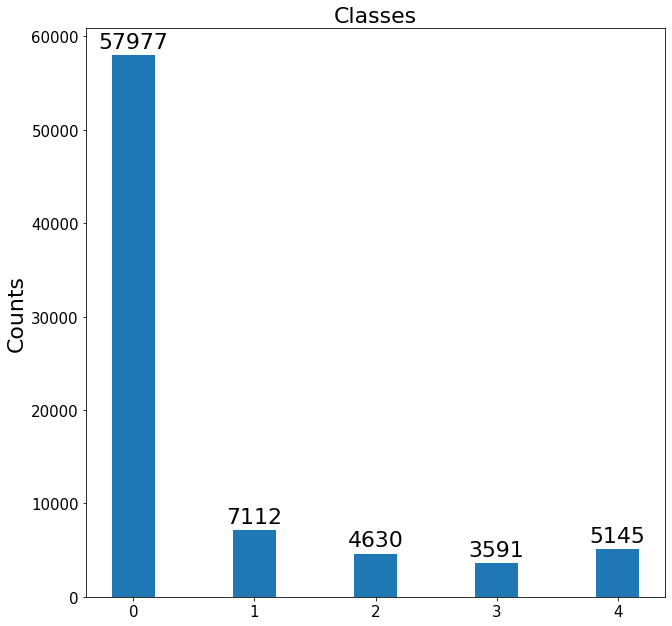

In [176]:
# Augment Classes belonging tp 1 and 3.

classes_to_augment=[1.0,3.0]
high_augmenters=[Reverse(),AddNoise(scale=0.01),AddNoise(scale=0.02),AddNoise(scale=0.03),AddNoise(0.04),AddNoise(scale=0.08)]
                 
#AddNoise(scale=0.5),AddNoise(scale=0.6),Pool(size=2,kind="ave"),Pool(size=2,kind="max"),Pool(size=2,kind="min"),Drift(max_drift=(0.1,0.5)),Quantize(n_levels=20),Drift(max_drift=(0.1,0.2)),Drift(max_drift=(0.1,0.4))]
low_augmenters=[Reverse(),AddNoise(scale=0.1),AddNoise(scale=0.2)]
to_stack=[]
for _class in classes_to_augment:
    
    indices=train_data_mit[:,-1]==_class
    length=np.sum(indices)
    if _class==3.0:
        for aug in high_augmenters:
            aug_val=aug.augment(train_data_mit[indices,:-1],train_data_mit[indices,:-1])
            to_stack.append(np.append(aug_val[0],np.ones((aug_val[0].shape[0],1))*_class,axis=1))
        
        
    if _class==1.0:
        # A little Low
        for aug in low_augmenters:
            #print(type(train_data_mit))
            #print()
            #print(train_data_mit[indices,:-1].shape)
            aug_val=aug.augment(train_data_mit[indices,:-1],train_data_mit[indices,:-1])
            to_stack.append(np.append(aug_val[0],np.ones((aug_val[0].shape[0],1))*_class,axis=1))
            
#print(len(to_stack))
for values in to_stack:
    print(values.shape)
    train_data_mit=np.vstack((train_data_mit,values))


label_types = np.unique(train_data_mit[:,-1])
examples_per_class=[]

for values in label_types:
    print("Class {0} {1} Examples".format(int(values),np.sum(train_data_mit[:,-1]==values)))
    examples_per_class.append(np.sum(train_data_mit[:,-1]==values))

plot_examples(label_types,examples_per_class)

In [15]:
def test_results(model,testloader,output_dict=False):
    #model.eval()
    model.eval()
    with torch.no_grad():
        all_preds=[]
        all_labels=[]
        for _,test_data in enumerate(testloader,0):
            test_data,test_labels=test_data[:,:-1],test_data[:,-1]
            test_data=test_data.view(-1,1,test_data.size()[1])
            #print(test_data.size())
            outputs=model(test_data.double())
            _,pred=torch.max(outputs,1)
            pred=pred.to(torch.double)
            test_labels=test_labels.to(torch.double)
            all_preds.extend(pred.tolist())
            all_labels.extend(list(test_labels))
        
    report=classification_report(all_labels,all_preds,output_dict=output_dict)
    return report,np.unique(all_labels)

In [177]:
torch.backends.cudnn.benchmark = False

weights=(max(examples_per_class)*1.0)/torch.Tensor(examples_per_class)

batch_size=512
dataloader=DataLoader(train_data_mit,shuffle=True,batch_size=batch_size)
testloader=DataLoader(test_data_mit,batch_size=batch_size)
valloader=DataLoader(cv_data_mit,batch_size=cv_data_mit.shape[0])

epochs=10

def get_best_model(num_epochs=5,trials=5):
    max_f1_score=float("-inf")
    best_model=None
    for trial in range(trials):
        model,loss,_optim=init(weights=weights.double())
        model=model.double()
        #print(loss.weights)
        for epoch in range(num_epochs):
            for batch_no,train_data in enumerate(dataloader,0):
                train_data,train_labels=train_data[:,:-1],train_data[:,-1]
                train_data=train_data.view(-1,1,train_data.size()[1])
                outputs=model(train_data.double())
                _optim.zero_grad()
                loss_func=loss(outputs,train_labels.long())
                loss_func.backward()
                _optim.step()
        print("Trial,",trial)

        report,labels=test_results(model.eval(),valloader,output_dict=True)
        f1_score=0.0
        for values in labels:
            f1_score+=report[str(values)]["f1-score"]
            #print(report[str(values)]["f1-score"])
        if max_f1_score<(f1_score/(float(labels.shape[0]))):
            max_f1_score=(f1_score/(float(labels.shape[0])))
            best_model=model
    return (best_model,loss,_optim),max_f1_score
        


model,score=get_best_model()
print(score)
print(test_results(model[0].eval(),valloader)[0])

Trial, 0
Trial, 1
Trial, 2
Trial, 3
Trial, 4
0.8241340164970907
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     14494
         1.0       0.58      0.84      0.69       445
         2.0       0.84      0.97      0.90      1158
         3.0       0.50      0.78      0.61       128
         4.0       0.92      0.99      0.95      1286

    accuracy                           0.95     17511
   macro avg       0.77      0.91      0.82     17511
weighted avg       0.96      0.95      0.96     17511



In [181]:
temp_storage=model
print(temp_storage)
#print(temp_storage[0].eval())

CNN(
  (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(4, 16, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=1152, bias=True)
  (fc2): Linear(in_features=1152, out_features=5, bias=True)
)


In [179]:
#Now let's early stop
patience=5
best_model,loss,_optim=model
model=model[0]
max_f1_score=score
num_epochs=20
improvement=0
for epoch in range(num_epochs):
    model.train()
    for batch_no,train_data in enumerate(dataloader,0):
        train_data,train_labels=train_data[:,:-1],train_data[:,-1]
        train_data=train_data.view(-1,1,train_data.size()[1])
        outputs=model(train_data.double())
        _optim.zero_grad()
        loss_func=loss(outputs,train_labels.long())
        loss_func.backward()
        _optim.step()
    
    report,labels=test_results(model.eval(),valloader,output_dict=True)
    f1_score=0.0
    for values in labels:
        f1_score+=report[str(values)]["f1-score"]

    if max_f1_score<(f1_score/(float(labels.shape[0]))):
        max_f1_score=(f1_score/(float(labels.shape[0])))
        best_model=model
        improvement=0
    else:
        improvement+=1
        
    if improvement==patience:
        break

report,_=test_results(best_model,testloader)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.87      0.76      0.81       556
         2.0       0.97      0.92      0.94      1448
         3.0       0.68      0.85      0.75       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.90      0.90     21892
weighted avg       0.98      0.98      0.98     21892



In [180]:
print(epoch)
report,_=test_results(best_model,valloader)
print(report)
print(max_f1_score)

16
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     14494
         1.0       0.88      0.78      0.82       445
         2.0       0.97      0.92      0.94      1158
         3.0       0.72      0.84      0.78       128
         4.0       0.98      0.98      0.98      1286

    accuracy                           0.98     17511
   macro avg       0.91      0.90      0.90     17511
weighted avg       0.98      0.98      0.98     17511

0.9125846495089389


In [44]:
def save_model(model,PATH):
    torch.save(model.state_dict(),PATH)

In [45]:
def load_and_return(model,path):
    model=CNN()
    model.load_state_dict(torch.load(path))
    return model
aug_model=load_and_return(CNN(),"best_cnn/best_5_class_model.pt")
no_aug_model = load_and_return(CNN(),"best_cnn/no_aug.pt")

Class 0 4046 Examples
Class 1 10506 Examples


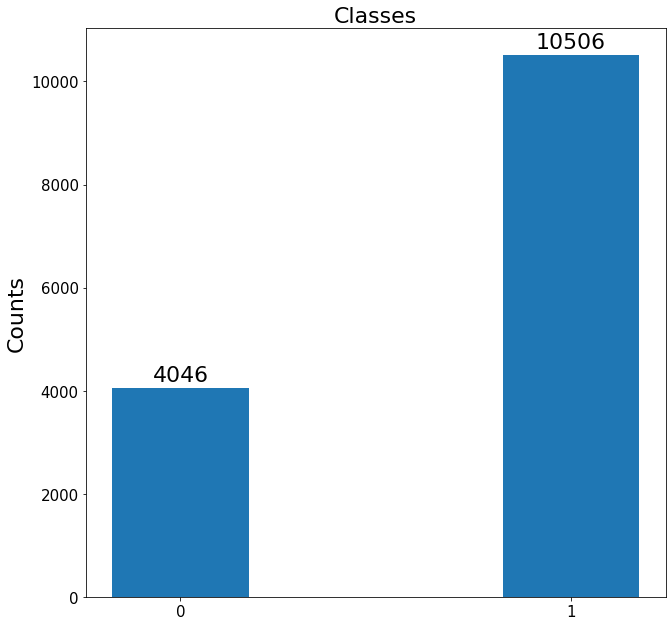

In [63]:
train_data_ab = np.genfromtxt('ptbdb_abnormal.csv', delimiter=',')
train_data_normal = np.genfromtxt('ptbdb_normal.csv', delimiter=',')
label_types = [0,1]
examples_per_class=[train_data_normal.shape[0],train_data_ab.shape[0]]

for indx,values in enumerate(label_types):
    print("Class {0} {1} Examples".format(int(values),examples_per_class[indx]))

plot_examples(label_types,examples_per_class,file_name='ptdb.png')

train_data=np.append(train_data_ab,train_data_normal,axis=0)
#np.random.shuffle(train_data)
assert train_data.shape[0]==sum(examples_per_class)

train_data,train_labels=train_data[:,:-1],train_data[:,-1]

In [64]:
batch_size=512
ptb_train_loader=DataLoader(train_data,batch_size=batch_size)
extracted_features=[]
models=[aug_model,no_aug_model]
aug_features=[]
for model in models:
    data_feat=None
    for _,values in enumerate(ptb_train_loader,0):
        aug_model.eval()
        aug_model.double()
        values=values.view(-1,1,values.size()[-1])
        with torch.no_grad():
            model.eval()
            feats=aug_model.feature_extract(values)
            if data_feat is None:
                data_feat=np.array(feats.numpy())
            else:
                data_feat=np.vstack((data_feat,feats.numpy()))
    aug_features.append(data_feat)
aug_data_feats,no_aug_feats=aug_features[0],aug_features[1]

In [65]:
def test_train_split(X,Y,random_state=1,split=0.8):
    return train_test_split(X,Y,train_size=split,stratify=Y)

aug_data,aug_test_data,aug_train_labels,aug_test_labels=test_train_split(aug_data_feats,train_labels)

In [72]:
def gaussian_nb(train_data,train_labels):
    validator=StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    gnb=GaussianNB()
    score=cross_val_score(gnb,train_data,train_labels,cv=validator)
    score=sum(score)/score.shape[0]
    gnb.fit(train_data,train_labels)
    return score,gnb,"Gaussian Naive Bayes"

print(score)
score,clf,name=gaussian_nb(aug_data,aug_train_labels)
pred=clf.predict(aug_test_data)
print(classification_report(aug_test_labels,pred))

0.7763088740650899
              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67       809
         1.0       0.92      0.75      0.83      2102

    accuracy                           0.77      2911
   macro avg       0.74      0.79      0.75      2911
weighted avg       0.82      0.77      0.78      2911



In [69]:
def tune_hyper_params_dt(train_data,train_labels):
    diff_depths=[3,5,7,9,12,15,18,None]
    max_depth_sol=None
    max_f1_score=float("-inf")
    for values in diff_depths:
        #print(values)
        validator=StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
        clf = tree.DecisionTreeClassifier(max_depth=values,random_state=0)
        score=cross_val_score(clf,train_data,train_labels,scoring='f1',cv=validator)
        score=sum(score)/len(score)
        if score>max_f1_score:
            max_depth_sol=values
            max_f1_score=score
    return max_f1_score,max_depth_sol    
        
    
def train_decision_tree(train_data,train_labels):
    score,max_depth=tune_hyper_params_dt(train_data,train_labels)
    clf=tree.DecisionTreeClassifier(random_state=0,max_depth=max_depth)
    clf.fit(train_data,train_labels)
    print("max_depth,score",max_depth,score)
    return score,clf,"Decision Tree"

score,clf,name=train_decision_tree(aug_data,aug_train_labels)
pred=clf.predict(aug_test_data)
print(classification_report(aug_test_labels,pred))

max_depth,score 15 0.9520114125572443
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89       809
         1.0       0.96      0.96      0.96      2102

    accuracy                           0.94      2911
   macro avg       0.93      0.93      0.93      2911
weighted avg       0.94      0.94      0.94      2911



In [74]:
def best_model(train_data,train_labels):
    models = ['linear', 'rbf', 'poly', 'sigmoid']
    C_VALS=[1,4,16,64,100]
    best_kernel = None
    max_f1_score=float("-inf")
    best_c_value=None
    for kernel in models:
        #print("Kernel",kernel)
        for values in C_VALS:
            #print("C value",values)
            validator=StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
            clf = svm.SVC(kernel = kernel,gamma='scale',C=values)
            score=cross_val_score(clf,train_data,train_labels,scoring='f1',cv=validator)
            score=sum(score)/len(score)
            if score>max_f1_score:
                best_kernel = kernel
                max_f1_score = score
                best_c_value=values
    return best_kernel,max_f1_score,best_c_value

# training the model using best kernel
def train_svm(train_data,train_labels):
    best_kernel,f1_score,best_c_value = best_model(train_data, train_labels)
    print("best_kernel:{0} f1_score:{1} C-Values:{2}".format(best_kernel, f1_score, best_c_value))
    clf = svm.SVC(kernel = best_kernel,gamma='scale',C=best_c_value)
    classifier = clf.fit(train_data,train_labels)
    return f1_score,classifier,"SVM with {0} Kernel".format(best_kernel)

score,clf,_ = train_svm(aug_data,aug_train_labels)
pred = clf.predict(aug_test_data)
report=classification_report(aug_test_labels,pred)
print(report)

best_kernel:rbf f1_score:0.9940611446457133 C-Values:16
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       809
         1.0       0.99      1.00      1.00      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



In [75]:
print("SVM Score",score)

SVM Score 0.9940611446457133


In [76]:
no_aug_train,no_aug_test,no_aug_train_labels,no_aug_test_labels=test_train_split(no_aug_feats,train_labels)

In [80]:
score,clf,name=gaussian_nb(no_aug_train,no_aug_train_labels)
pred=clf.predict(no_aug_test)
print(score)
print(classification_report(no_aug_test_labels,pred))

0.775190264984013
              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67       809
         1.0       0.92      0.74      0.82      2102

    accuracy                           0.77      2911
   macro avg       0.74      0.79      0.74      2911
weighted avg       0.82      0.77      0.78      2911



In [81]:
score,clf,name=train_decision_tree(no_aug_train,no_aug_train_labels)
pred=clf.predict(no_aug_test)
print(score)
print(classification_report(no_aug_test_labels,pred))

max_depth,score 18 0.953692722598802
0.953692722598802
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       809
         1.0       0.96      0.95      0.95      2102

    accuracy                           0.93      2911
   macro avg       0.91      0.92      0.92      2911
weighted avg       0.93      0.93      0.93      2911



In [82]:
score,clf,_ = train_svm(no_aug_train,no_aug_train_labels)
pred=clf.predict(no_aug_test)
print(score)
print(classification_report(no_aug_test_labels,pred))

best_kernel:rbf f1_score:0.994648935986133 C-Values:16
0.994648935986133
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       809
         1.0       0.99      0.99      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911

